# Zadania
1. Utwórz dwie nowe kolumny w ramce "Countries", w których powierzchnia i gęstość zaludnienia wyrażone sa odpowiednio w milach kwadratowych i osobach na milę kwadratową. (1 pkt) 
  - Przelicznik: 1 km kwadratowy = 0.386102 mili kwadratowej (powierzchnię należy pomnożyć, a gęstość zaludnienia podzielić przez ten współczynnik)
  - Typami nowych kolumn mają być odpowiednio integer (powierzchnia) i float (gęstość). Zaokrąglanie do integer: "int(x)"
  - Nazwy nowych kolumn proszę ustawić odpowiednio na '<tt>Area (sq mi)</tt>' oraz '<tt>Pop Density (per sq mi)</tt>'
1. Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju. (3 pkt) 
  - Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
  - Wskazówka: w pierwszym etapie stwórz ramkę agregującą liczbę lotnisk w zależności od kraju. W drugim etapie złącz (join) tę ramkę z ramką countries. Kolumną wspólną (warunkiem złączenia) będzie Country.
  - Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy. 
  - Następnie zmień nazwy kilku największych państw w jednej z ramek, tak żeby ujednolicić nazwy. Można to zrobić funkcją replace:
<br><tt>cdf=cdf.replace(['Korea, South', 'Korea, North'], ['South Korea', 'North Korea'], 'Country')</tt>
1. Do ramki "Countries" dodaj nową kolumnę "Continent" (według klasyfikacji Africa, Asia, Europe, North America, South America, Antarctica, Australia/Oceania). (2 pkt)
  - Skorzystaj z kolumny "Region" i pomocniczej funkcji (UDF) mapującej region na kontynent. 
  - (dodatkowy 1 pkt) Zamiast mapowania na podstawie Region, stwórz funkcję mapująca współrzędne na kontynent, np. wykorzystując geopandas i funkcję dissolve ([przykład](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html))
1. Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym. (1 pkt)


In [33]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [34]:
from pyspark.sql import SparkSession

In [35]:
import pandas as pd

In [36]:
import numpy as np

In [37]:
spark = SparkSession.builder.getOrCreate()

In [38]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [39]:
# Wbudowane funkcje, które mogą być przydatne:
# - udf: służy do tworzenia funkcji użytkownika
# - trim: usuwa białe spacje z początku i końca stringu
# - isnull: testuje, czy wartość jest pusta
from pyspark.sql.functions import col, udf, trim, isnull
from pyspark.sql.types import FloatType, IntegerType

In [40]:
def to_float (s) :
   return float(s.replace(',','.'))
float_udf = udf(to_float , FloatType())

In [41]:
countries = spark.read.csv("countries of the world.csv",inferSchema=True,header=True)

# Usuwa kropki z wszystkich nazw kolumn (powodują wiele błędów, prawdopodobnie bug w Sparku)
# (Nb. wszystkie inne metody zmiany tych nazw (np. użycie columnRenamed) zawiodły)
new_columns=[s.replace('.','') for s in countries.columns]
countries=countries.toDF(*new_columns) # tutaj '*' to operator "splat" -- robi z tablicy listę argumentów

# Tak można ustawić wyświetlanie większej liczby wierszy w Jupyterze
# pd.set_option('display.max_rows', 20) (niedostępne w colabie)
display(countries.limit(10).toPandas())

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
5,Angola,SUB-SAHARAN AFRICA,12127071,1246700,"9,7","0,13",0,"191,19",1900,"42,0","7,8","2,41","0,24","97,35",None,"45,11","24,2","0,096","0,658","0,246"
6,Anguilla,LATIN AMER. & CARIB,13477,102,"132,1","59,80","10,76","21,03",8600,"95,0","460,0",0,0,100,2,"14,17","5,34","0,04","0,18","0,78"
7,Antigua & Barbuda,LATIN AMER. & CARIB,69108,443,"156,0","34,54","-6,15","19,46",11000,"89,0","549,9","18,18","4,55","77,27",2,"16,93","5,37","0,038","0,22","0,743"
8,Argentina,LATIN AMER. & CARIB,39921833,2766890,"14,4","0,18","0,61","15,18",11200,"97,1","220,4","12,31","0,48","87,21",3,"16,73","7,55","0,095","0,358","0,547"
9,Armenia,C.W. OF IND. STATES,2976372,29800,"99,9","0,00","-6,47","23,28",3500,"98,6","195,7","17,55","2,3","80,15",4,"12,07","8,23","0,239","0,343","0,418"


# Zadanie 1: nowe kolumny

In [42]:
from pyspark.sql.functions import col

# Utworzenie kolumny z powierzchnią w milach kwadratowych
countries = countries.withColumn("Area (sq mi)2", col("Area (sq mi)") * 0.386102)

# Utworzenie kolumny z gęstością zaludnienia na milę kwadratową
countries = countries.withColumn("Pop Density (per sq mi)2", col("Population") / (col("Area (sq mi)") * 0.386102))

# Zaokrąglenie kolumny z powierzchnią do integer
countries = countries.withColumn("Area (sq mi)2", col("Area (sq mi)").cast("integer"))

#knwertujemy kolumnę "Pop Density (per sq mi)2" na typ zmiennoprzecinkowy
countries = countries.withColumn("Pop Density (per sq mi)2", col("Pop Density (per sq mi)2").cast("float"))

#przyciecie
countries = countries.withColumn('Country', trim(countries['Country']))

# Wyświetlenie wynikowej ramki danych
display(countries.limit(10).toPandas())

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Area (sq mi)2,Pop Density (per sq mi)2
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700,"36,0",...,"0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38",647500,124.227470
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500,"86,5",...,"4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579",28748,322.681488
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000,"70,0",...,"0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298",2381740,35.809357
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000,"97,0",...,15,75,2,"22,46","3,27",None,None,None,199,752.190125
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000,"100,0",...,0,"97,78",3,"8,71","6,25",None,None,None,468,394.038086
5,Angola,SUB-SAHARAN AFRICA,12127071,1246700,"9,7","0,13",0,"191,19",1900,"42,0",...,"0,24","97,35",None,"45,11","24,2","0,096","0,658","0,246",1246700,25.193697
6,Anguilla,LATIN AMER. & CARIB,13477,102,"132,1","59,80","10,76","21,03",8600,"95,0",...,0,100,2,"14,17","5,34","0,04","0,18","0,78",102,342.208679
7,Antigua & Barbuda,LATIN AMER. & CARIB,69108,443,"156,0","34,54","-6,15","19,46",11000,"89,0",...,"4,55","77,27",2,"16,93","5,37","0,038","0,22","0,743",443,404.038300
8,Argentina,LATIN AMER. & CARIB,39921833,2766890,"14,4","0,18","0,61","15,18",11200,"97,1",...,"0,48","87,21",3,"16,73","7,55","0,095","0,358","0,547",2766890,37.369434
9,Armenia,C.W. OF IND. STATES,2976372,29800,"99,9","0,00","-6,47","23,28",3500,"98,6",...,"2,3","80,15",4,"12,07","8,23","0,239","0,343","0,418",29800,258.683594


# Join examples

# Zadanie 2: zależność liczby lotnisk od powierzchni kraju 

In [43]:
airports = spark.read.csv("airports.csv",inferSchema=True,header=True)

column_names = ["ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "Tz database time zone", "Type", "Source"]

airports = airports.toDF(*column_names)

display(airports.limit(10).toPandas())

,ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
1,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
2,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
3,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
4,6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports
5,7,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,BGBW,61.160500,-45.425999,112,-3,E,America/Godthab,airport,OurAirports
6,8,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,BGGH,64.190903,-51.678101,283,-3,E,America/Godthab,airport,OurAirports
7,9,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,BGSF,67.012222,-50.711603,165,-3,E,America/Godthab,airport,OurAirports
8,10,Thule Air Base,Thule,Greenland,THU,BGTL,76.531197,-68.703201,251,-4,E,America/Thule,airport,OurAirports
9,11,Akureyri Airport,Akureyri,Iceland,AEY,BIAR,65.660004,-18.072701,6,0,N,Atlantic/Reykjavik,airport,OurAirports


In [44]:
# TODO
# zacznij od stworzenia ramki, która zawiera posortowaną liczbę lotnisk w poszczególnych krajach
from pyspark.sql.functions import count
airports_per_country = airports.groupBy('Country').agg(count('IATA').alias('Number of airports'))
sorted_airports = airports_per_country.orderBy('Number of airports', ascending=False)
display(sorted_airports.toPandas())

,Country,Number of airports
0,United States,1435
1,Canada,416
2,Australia,296
3,Germany,241
4,Russia,238
...,...,...
232,Gambia,1
233,Luxembourg,1
234,Wake Island,1
235,Bermuda,1


In [45]:
import pyspark.sql.functions as F

In [46]:
# TODO złączenie ramek i wykres

merged_df = sorted_airports.join(countries.select('Country', 'Area (sq mi)2'), on='Country', how='full')
display(merged_df.toPandas())

,Country,Number of airports,Area (sq mi)2
0,Afghanistan,20.0,647500.0
1,Albania,5.0,28748.0
2,Algeria,43.0,2381740.0
3,American Samoa,2.0,199.0
4,Andorra,NaN,468.0
...,...,...,...
254,West Bank,1.0,5860.0
255,Western Sahara,3.0,266000.0
256,Yemen,11.0,527970.0
257,Zambia,12.0,752614.0


In [47]:
import matplotlib.pyplot as plt
merged_df = merged_df.toPandas()

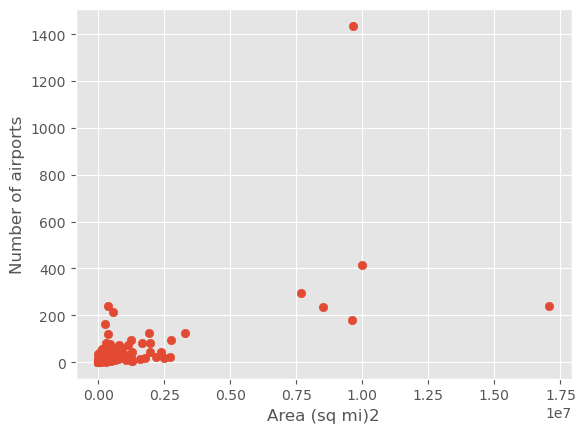

In [48]:
plt.scatter(merged_df['Area (sq mi)2'], merged_df['Number of airports'])
plt.xlabel('Area (sq mi)2')
plt.ylabel('Number of airports')
plt.show()

# Zadanie 3

In [57]:
from pyspark.sql.functions import udf

def region_to_continent(region):
    if region in ['ASIA (EX. NEAR EAST)', 'NEAR EAST', 'C.W. OF IND. STATES']:
        return 'Asia'
    elif region == 'EASTERN EUROPE':
        return 'Europe'
    elif region == 'NORTHERN AFRICA':
        return 'Africa'
    elif region in ['OCEANIA', 'AUSTRALASIA']:
        return 'Australia/Oceania'
    elif region == 'WESTERN EUROPE':
        return 'Europe'
    elif region == 'SUB-SAHARAN AFRICA':
        return 'Africa'
    elif region == 'LATIN AMER. & CARIB':
        return 'South America'
    elif region in ['NORTHERN AMERICA', 'CARIBBEAN']:
        return 'North America'
    elif region in ['Dem. Rep. Korea', 'South Korea']:
        return 'Asia'
    elif region == 'BALTICS':
        return 'Europe'
    elif region in ['North', 'South']:
        return 'Antarctica'
    elif region == 'FEDERATED STATES OF MICRONESIA':
        return 'Australia/Oceania'
    elif region == 'MELANESIA':
        return 'Australia/Oceania'
    elif region == 'POLYNESIA':
        return 'Australia/Oceania'
    else:
        return 'Unknown'



In [70]:
region_to_continent_udf = udf(region_to_continent)

countries = countries.withColumn("Continent", region_to_continent_udf(countries["Region"]).cast("string"))


In [71]:
print(countries.show())

Py4JJavaError: An error occurred while calling o497.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 77.0 failed 1 times, most recent failure: Lost task 0.0 in stage 77.0 (TID 53) (Wojciech executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:157)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 24 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2238)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2259)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2278)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:506)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:459)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:48)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3868)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2863)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3084)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:288)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:327)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:157)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 24 more


# Zadanie 4

In [ ]:
# TODO

In [68]:
merged_df2 = sorted_airports.join(countries.select('Country', 'Area (sq mi)2', 'Continent'), on='Country', how='full')
display(merged_df2.toPandas())

Py4JJavaError: An error occurred while calling o458.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 76.0 failed 1 times, most recent failure: Lost task 0.0 in stage 76.0 (TID 52) (Wojciech executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:157)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:157)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 26 more
